In [1]:
import sys
sys.path.append('../../datasets/')
from prepare_sequences import prepare, germanBats
import matplotlib.pyplot as plt

classes = germanBats

In [2]:
num_bands = 257
patch_len = 44                               # = 250ms ~ 25ms
patch_skip = patch_len / 2                   # = 150ms ~ 15ms

resize = None

mode = 'slide'
options = {
    'seq_len': 60,                            # = 500ms with ~ 5 calls
    'seq_skip': 15,
}

X_test, Y_test = prepare("../../datasets/prepared.h5", classes, patch_len, patch_skip,
                                                         options, mode, resize, only_test=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:36<00:00,  2.06s/it]


In [3]:
print("Total sequences:", len(X_test))
print(X_test.shape, Y_test.shape)

Total sequences: 4979
(4979, 60, 44, 257) (4979,)


In [4]:
import time
import datetime
import numpy as np
import tqdm
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

In [5]:
batch_size = 64
num_classes = len(list(classes))

test_data = TensorDataset(torch.Tensor(X_test), torch.from_numpy(Y_test))
test_loader = DataLoader(test_data, batch_size=batch_size)

In [6]:
from bat_2 import Net

max_len = 60
d_model = 64 

nhead = 2
dim_feedforward = 32
num_layers = 2
dropout = 0.3
classifier_dropout = 0.3

model = Net(
    max_len=max_len,
    patch_dim=resize[0]*resize[1] if resize is not None else patch_len * num_bands, # patch_len * num_bands, # 44 * 257 = 11,308
    d_model=d_model,
    num_classes=len(list(classes)),
    nhead=nhead,
    dim_feedforward=dim_feedforward,
    num_layers=num_layers,
    dropout=dropout,
    classifier_dropout=classifier_dropout,
)
model.load_state_dict(torch.load('bat_2_convnet.pth'))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model, device_ids=[0, 1])
    
model.to(device)
print(device)

cuda:0


In [7]:
corrects = 0.0

pred = []
true = []

model.eval()

# iterate over test data
for inputs, labels in tqdm.tqdm(test_loader):
    inputs, labels = inputs.to(device), labels.to(device)
    
    output = model(inputs) # Feed Network
    prediction = torch.argmax(output, 1)
    corrects += (prediction == labels).sum()
    
print("Test acc:", corrects / len(test_data))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:05<00:00, 14.29it/s]


Test acc: tensor(0.8215, device='cuda:0')


In [8]:
import random

def one_hot(x, num_classes, on_value=1., off_value=0., device='cuda'):
    x = x.long().view(-1, 1)
    return torch.full((x.size()[0], num_classes), off_value, device=device).scatter_(1, x, on_value)

def rand_y(Y, exclude_class):
    while True:
        idx = random.randint(0, len(Y)-1)
        if torch.logical_and(Y[idx], exclude_class).sum() == 0:
            return idx

def mixup(X, Y, num_classes, min_seq=2, max_seq=2):
    Y1 = one_hot(Y, num_classes, device=X.device)
    X2 = X.clone()
    Y2 = Y1.clone()
    for i, y in enumerate(Y):
        rand_k = random.randint(min_seq, max_seq)
        for k in range(3-rand_k):
            idx = rand_y(Y1, Y2[i])
            X2[i] += X[idx].squeeze()
            Y2[i] += Y1[idx].squeeze()
    return X2, Y2

def getCorrects(output, target):
    n_targets = target.sum(dim=1).int().cpu().detach().numpy()
    best_2 = torch.zeros_like(output)
    for i, e in enumerate(torch.argsort(output, 1)):
        best_2[i, e[-n_targets[i]:]] = 1
    log_and = torch.logical_and(best_2, target)
    corr = 0.0
    for i, t in enumerate(target):
        corr += log_and[i].sum() / t.sum()
    return corr

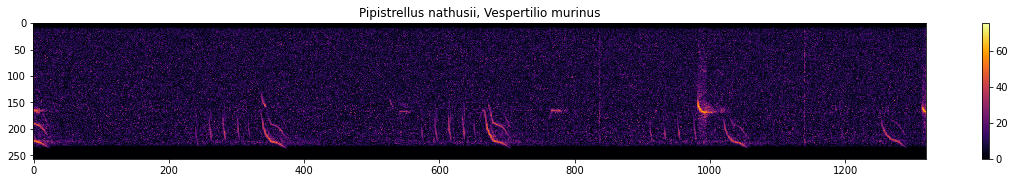

In [9]:
def stitch(a, r):
    return a[::r]
  
def plot_sequence(seq, y):
    plt.figure(figsize = (20, 2.5))
    stitched = stitch(seq, int(patch_len / patch_skip))
    spec = np.rot90(np.concatenate(stitched))
    plt.imshow(spec, interpolation='nearest', aspect='auto', cmap='inferno')
    plt.colorbar()
    label_list = []
    if(len(y.shape) > 0):
        for i in np.argwhere(y == 1)[:,0]:
            label_list.append(list(classes)[i])
        plt.title(", ".join(label_list))
    else:
        plt.title(list(classes)[y])

k = random.randint(0, batch_size-1)
X1, Y1 = next(iter(test_loader))
X1, Y1 = mixup(X1, Y1, num_classes=num_classes, min_seq=1, max_seq=3)
plot_sequence(X1[k].detach().numpy(), Y1[k].detach().numpy())

In [10]:
torch.cuda.empty_cache() 

In [11]:
mixed_corrects = 0.0
repeats = 5

predictions = []
targets = []

for r in range(repeats):
    # iterate over test data
    for inputs, labels in tqdm.tqdm(test_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        inputs, labels = mixup(inputs, labels, num_classes=num_classes, min_seq=1, max_seq=3)

        output = model(inputs) # Feed Network
        predictions.extend(output.data.cpu().numpy())
        targets.extend(labels.data.cpu().numpy())
        mixed_corrects += getCorrects(output, labels)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:11<00:00,  6.56it/s]


In [12]:
from sklearn.metrics import hamming_loss, f1_score

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

print("Mixed test acc:", mixed_corrects / (repeats * len(test_data)))
print("Mixed hamming score:", hamming_loss(sigmoid(np.asarray(predictions)) > 0.5, np.asarray(targets)))
print("Mixed f1 micro:", f1_score(sigmoid(np.asarray(predictions)) > 0.5, np.asarray(targets), average='micro'))
print("Mixed f1 macro:", f1_score(sigmoid(np.asarray(predictions)) > 0.5, np.asarray(targets), average='macro'))
print("Mixed f1 samples:", f1_score(sigmoid(np.asarray(predictions)) > 0.5, np.asarray(targets), average='samples'))

Mixed test acc: tensor(0.5757, device='cuda:0')
Mixed hamming score: 0.41451875655531006
Mixed f1 micro: 0.3030855582068945
Mixed f1 macro: 0.2823810368396244
Mixed f1 samples: 0.29935146428211423
